# Smart Meter Playbook

<p>
Mal Minhas, v0.1<br>
14.07.24
</p>
<p>
<h4>Versions</h4>
<ul>
<li><b>v0.1</b>: 14.07.24. First version</li>
</ul>
</p>

### 1. Introduction

tbd - something in here on how the whole system works

### 2. n3rgy API

First of all you need to sign up as a consumer at the n3rgy portal sign up page [here](https://data.n3rgy.com/consumer-sign-up).  You will need your MPAN and IDH MAC.  The sign up involves providing your consent to allow n3rgy to access and store your smart meter data.   Once you have done that you will be able to access your data.  The recipe provided in Github [here](https://github.com/n3rgy/consumer-data) is not particularly helpful.  After inspecting what happens in the web browser in the [consumer portal](https://data.n3rgy.com/consumer/download-data) when you download your data, the structure of the url needed becomes apparent:

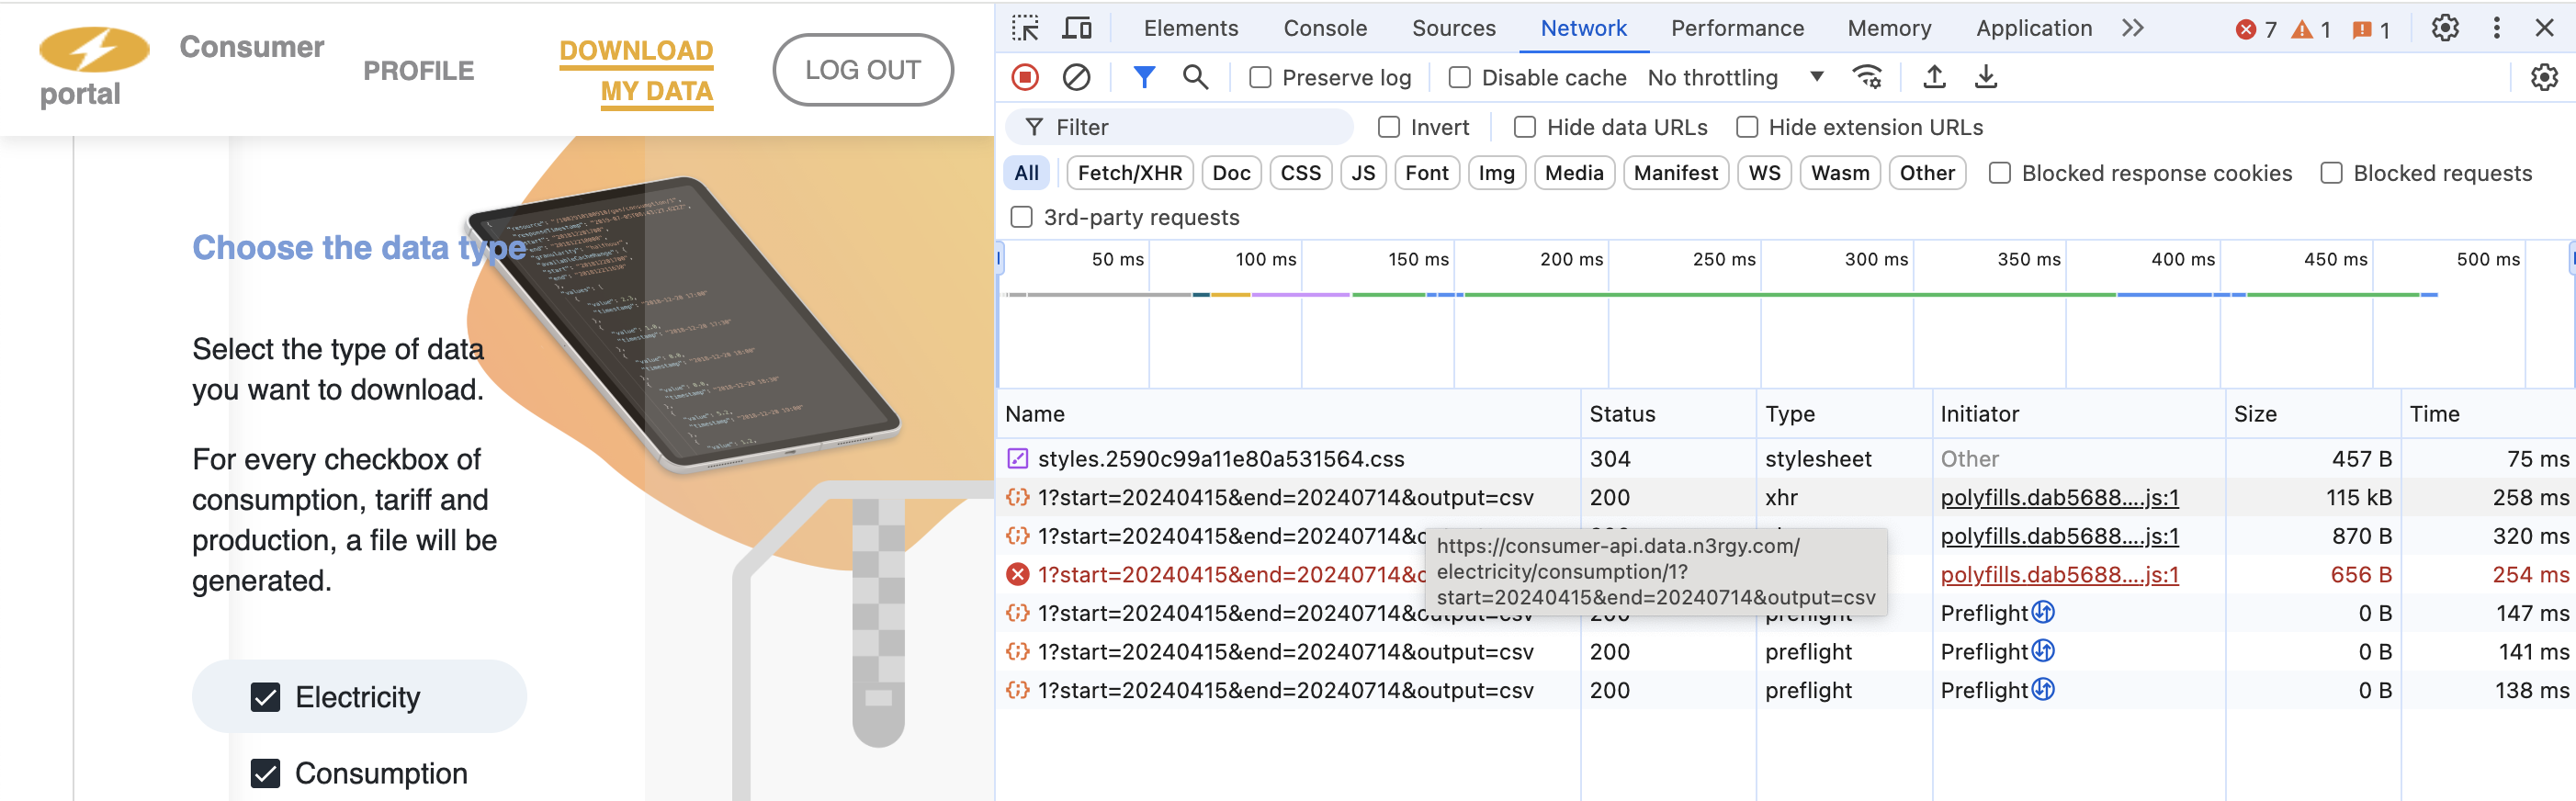

You are required to provide your IDH_MAC in your auth header.  The following code demonstrates how to retrieve the last three months of electricity data:

In [1]:
import os
import requests

MPAN = os.environ.get('MPAN')
IDH_MAC = os.environ.get('IDH_MAC')

def getDataInRange(start, end, fmt):
    url = f"https://consumer-api.data.n3rgy.com/electricity/consumption/1?start={start}&end={end}&output={format}"
    headers = {'Authorization': IDH_MAC}
    r = requests.get(url=url, headers=headers)
    assert(r.status_code == 200)
    return r.json()
    
start = '20240415'
end = '20240714'
fmt = 'json'
d = getDataInRange(start, end, fmt)

Let's print the keys:

In [2]:
print(f"keys = {list(d.keys())}")
print(f"resource = {d.get('resource')}")
print(f"responseTimestamp = {d.get('responseTimestamp')}")
print(f"start = {d.get('start')}")
print(f"end = {d.get('end')}")
print(f"granularity = {d.get('granularity')}")
print(f"{len(d.get('values'))} values")
print(f"availableCacheRange = {d.get('availableCacheRange')}")
print(f"unit = {d.get('unit')}")

keys = ['resource', 'responseTimestamp', 'start', 'end', 'granularity', 'values', 'availableCacheRange', 'unit']
resource = /electricity/consumption/1
responseTimestamp = 2024-07-14T01:20:32.327Z
start = 202404150030
end = 202407140000
granularity = halfhour
4314 values
availableCacheRange = {'start': '202312070000', 'end': '202407132100'}
unit = kWh


Let's convert those values into in a `pandas` dataframe and print the top 5 values:

In [3]:
import pandas as pd

def tweak_df(df):
    ts = pd.to_datetime(df.timestamp)
    return (df
            .rename(columns={'value':'kWh'})
            .assign(timestamp=ts)
            .set_index('timestamp')
           )
    
df = pd.DataFrame(d.get('values'))
df2 = tweak_df(df)
df2.head(5)

,kWh
timestamp,
2024-04-15 00:30:00,0.002
2024-04-15 01:00:00,0.003
2024-04-15 01:30:00,0.000
2024-04-15 02:00:00,0.000
2024-04-15 02:30:00,0.004


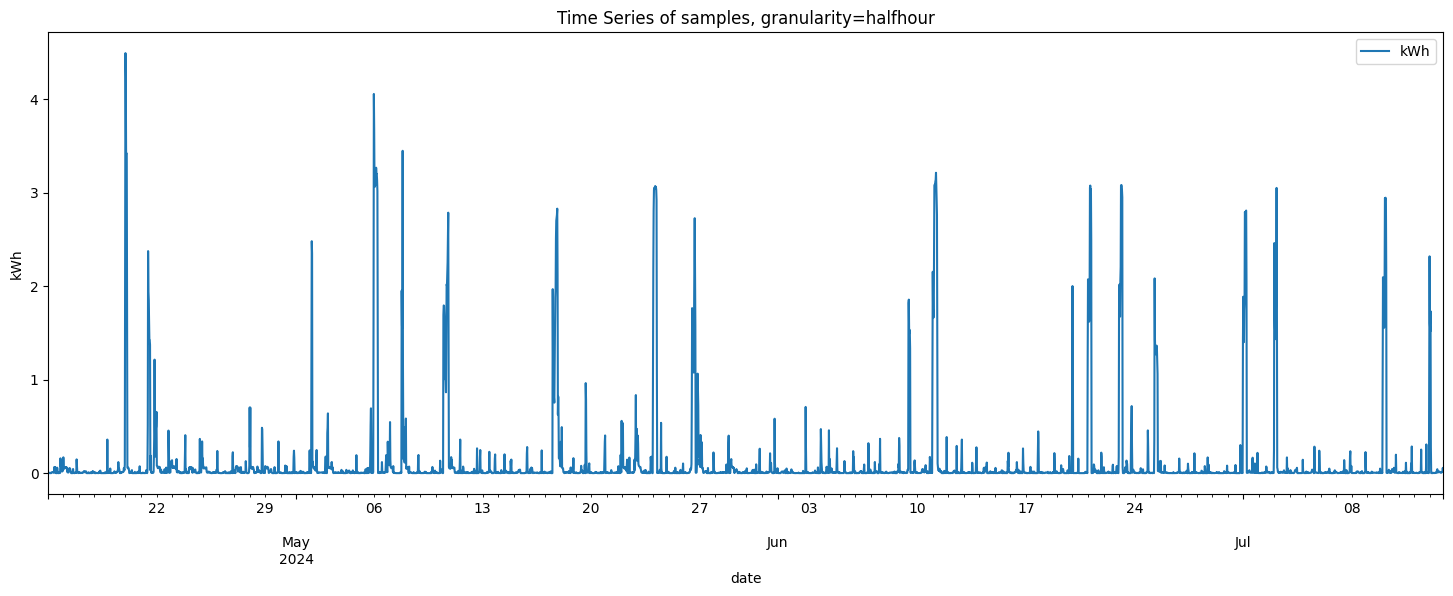

In [4]:
_ = df2.plot(figsize=(18,6), title=f"Time Series of samples, granularity={d.get('granularity')}", xlabel='date', ylabel='kWh')

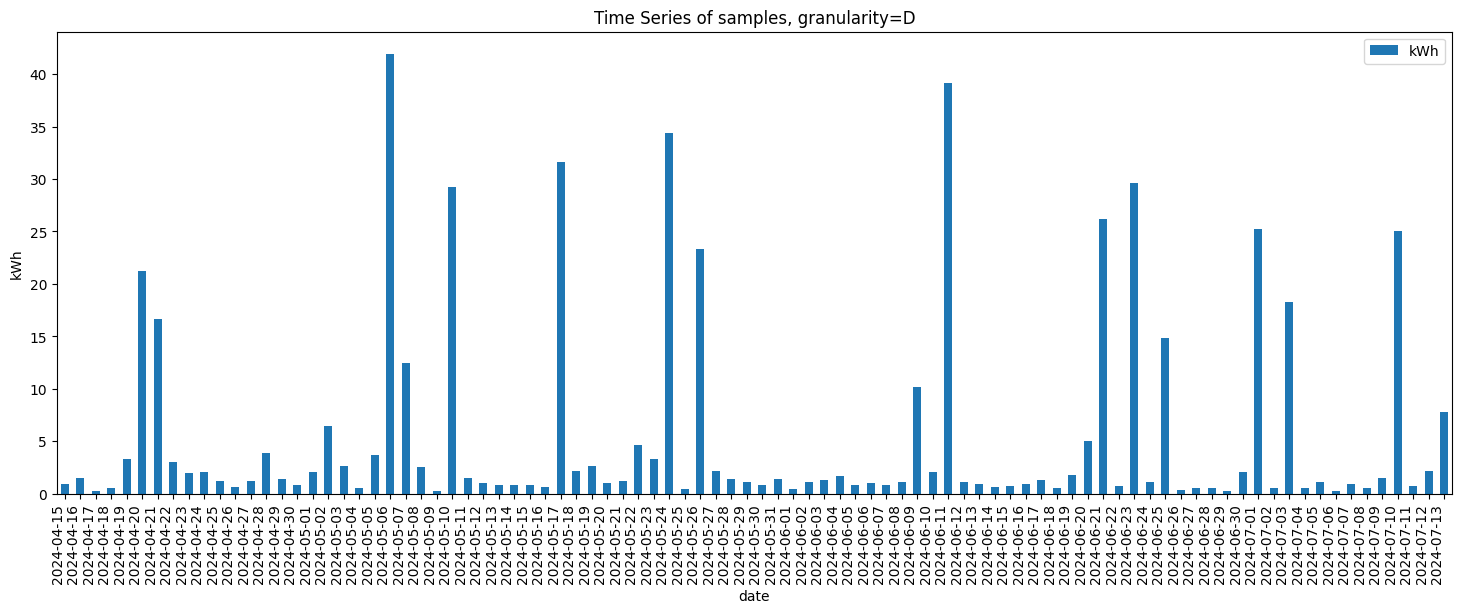

In [5]:
def plotResampledTimeSeries(period, angle):
    df2_resampled = df2.resample(period).sum()
    # Plotting the resampled data
    ax = df2_resampled.plot(kind='bar', figsize=(18, 6), title=f"Time Series of samples, granularity={period}", xlabel='date', ylabel='kWh')
    # Formatting the x-axis to show only dates
    ax.set_xticklabels(df2_resampled.index.strftime('%Y-%m-%d'), rotation=angle, ha='right')

period = 'D'
angle = 90
plotResampledTimeSeries(period, angle)